### Outlier Factors for Device Profiling

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=10000)

df.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

#df = pd.read_csv('../../../diploma/generated_data/500_400000(non_uniform)_1-200_True_C4_7.txt', header=None)

#df.columns = ['time', 'source computer', 'byte count']

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.sort_index(inplace=True)
df.head()

,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [2]:
# or try a simple generated dataset
len(df)

10000

In [3]:
from sklearn.preprocessing import MinMaxScaler

def scale(x):
    return np.log(x + 1)
   

class customScaler():
    def __init__(self, feature_range=(1,100)):
        self.feature_range = feature_range
    
    def fit(self, x):
        scaled_data = scale(x)
        self.scaler = MinMaxScaler(feature_range=self.feature_range)
        self.scaler.fit(scaled_data)

    def transform(self, data):
        scaled_data = scale(data)
        transformed = self.scaler.transform(scaled_data).astype(int)
        return np.array(transformed, dtype=np.int64)

In [4]:
from helper import group_data

scaler = customScaler()

groupped_data, hosts = group_data(df, size_of_bin_seconds=50, doScale=True, scaler=scaler)

In [5]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories

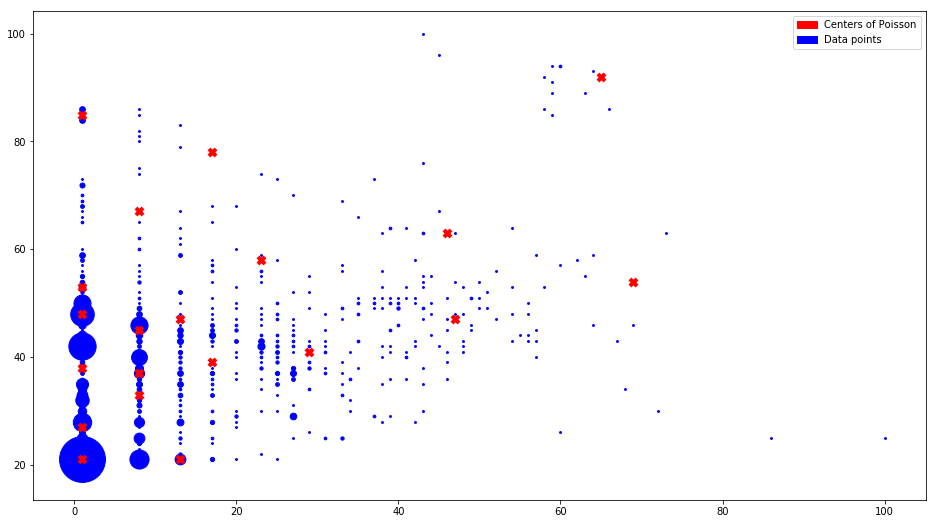

In [6]:
from helper import get_random_initialize_lamdas
from kplusplus import KPlusPlus

mixtures = 20

kplusplus = KPlusPlus(mixtures, groupped_data.values[:,:-1])

kplusplus.init_centers()

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, 500, n_clusters=20)
plot_points(groupped_data.values[:,:-1], onlineEM)

In [7]:
len(groupped_data.values)

2757

In [8]:
onlineEM.fit(groupped_data.values)

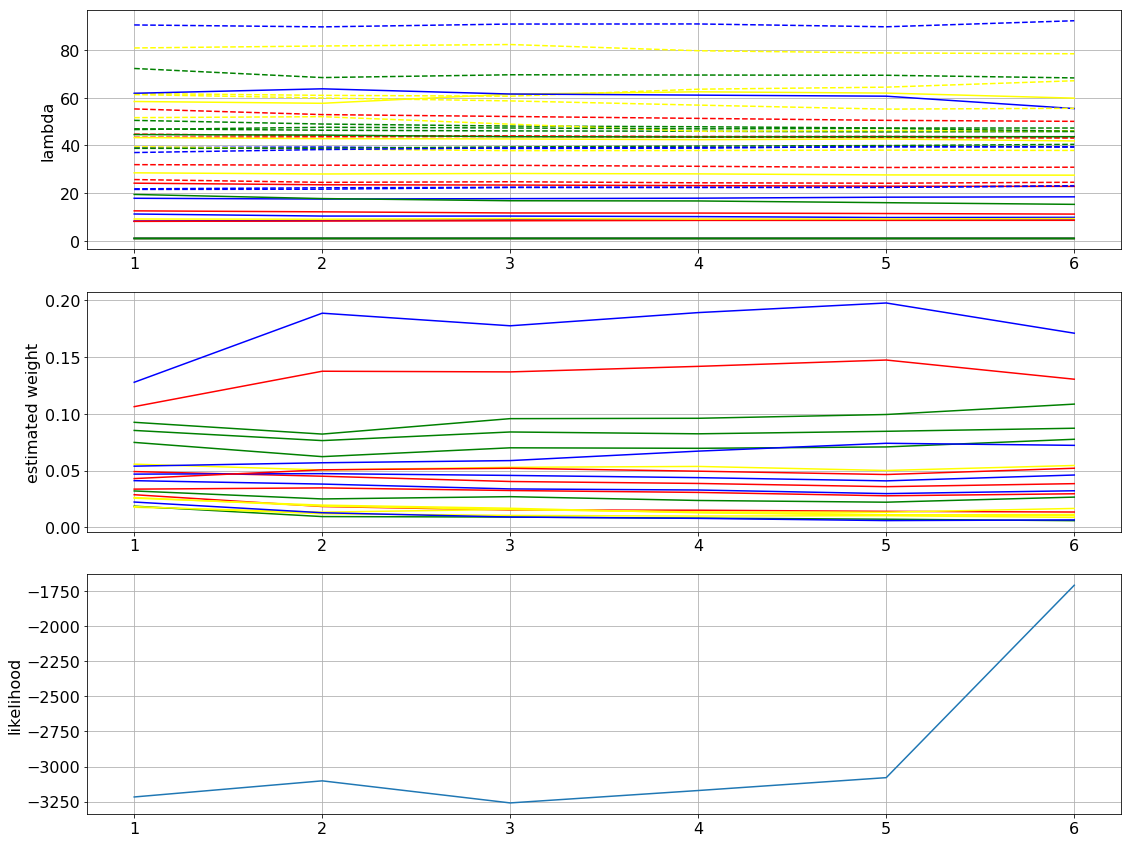

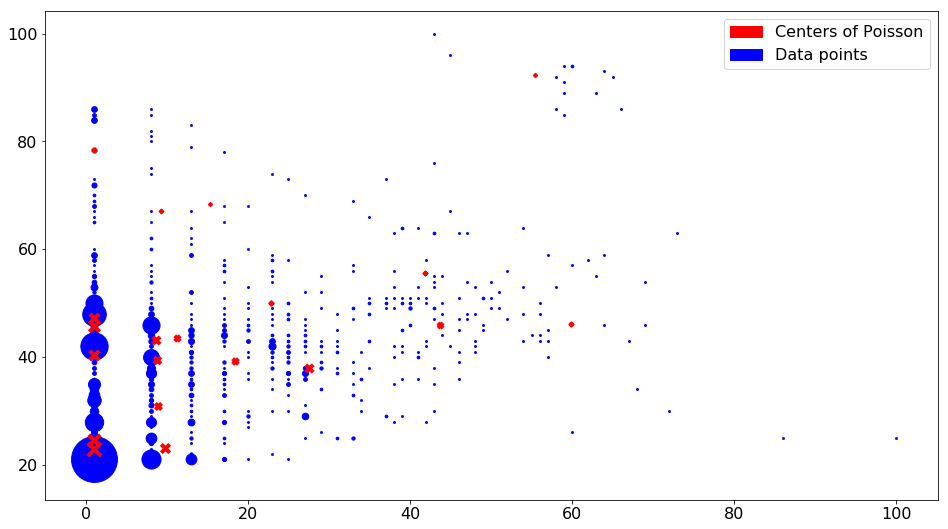

In [9]:
plot_results(onlineEM, legend=False)
plot_points(groupped_data.values[:,:-1], onlineEM)

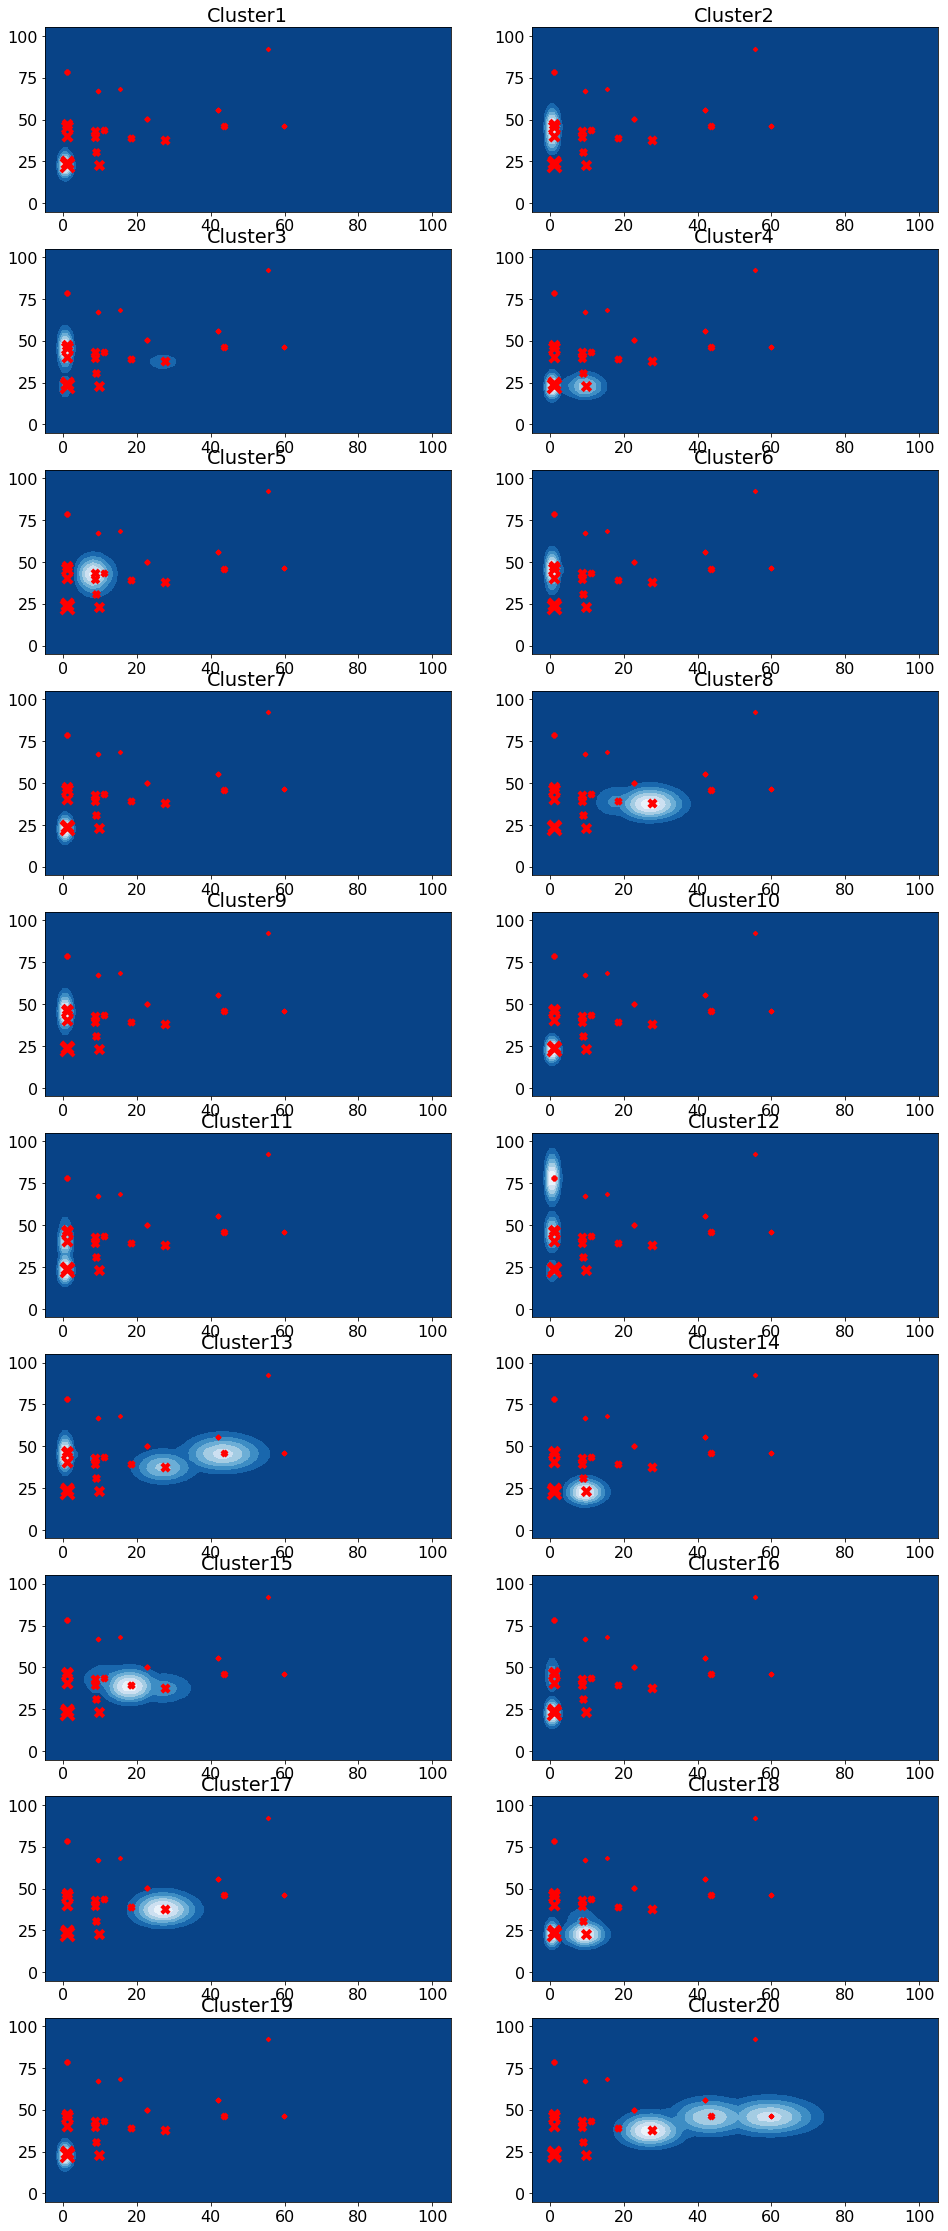

In [10]:
plot_all_categories(onlineEM)

### How to choose the correct number of categories

try the elbow method

see also gap statistic

In [24]:
from sklearn.cluster import KMeans

In [22]:
closest_centers = []

for host in onlineEM.hosts.keys():
    closest_centers.append(onlineEM.hosts[host]['group'])

In [25]:
cluster_sizes = range(3, 10)

cluster_scores = []

for k in cluster_sizes:
    km = KMeans(k, random_state=77)
    km.fit(closest_centers)
    cluster_scores.append(km.inertia_)

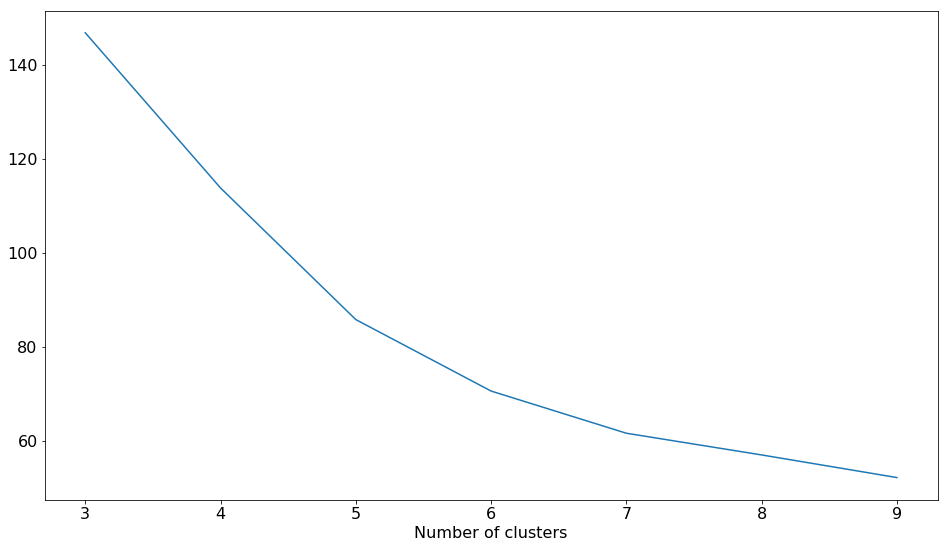

In [28]:
import matplotlib.pyplot as plt 

plt.plot(cluster_sizes, cluster_scores)
plt.xlabel('Number of clusters')
plt.show()

In [31]:
# try 7 clusters

n_clusters = 7

onlineEM.probabilities_per_kMean_cluster = np.zeros(shape=(n_clusters, self.m))
# each cluster has a number of hosts in it
onlineEM.counts_per_kMeans_cluster = np.zeros(n_clusters)
        
onlineEM.kMeans = KMeans(n_clusters, random_state=77)
onlineEM.kMeans.fit(closest_centers)

for host in onlineEM.hosts.keys():
    category = onlineEM.kMeans.predict([onlineEM.hosts[host]['group']])[0]
    onlineEM.hosts[host]['category'] = category
    points_in_cluster = onlineEM.counts_per_kMeans_cluster[category]

    onlineEM.probabilities_per_kMean_cluster[category] = \
        (onlineEM.probabilities_per_kMean_cluster[category] * points_in_cluster + onlineEM.hosts[host]['group']) / \
        (points_in_cluster + 1)

    onlineEM.counts_per_kMeans_cluster[category] += 1

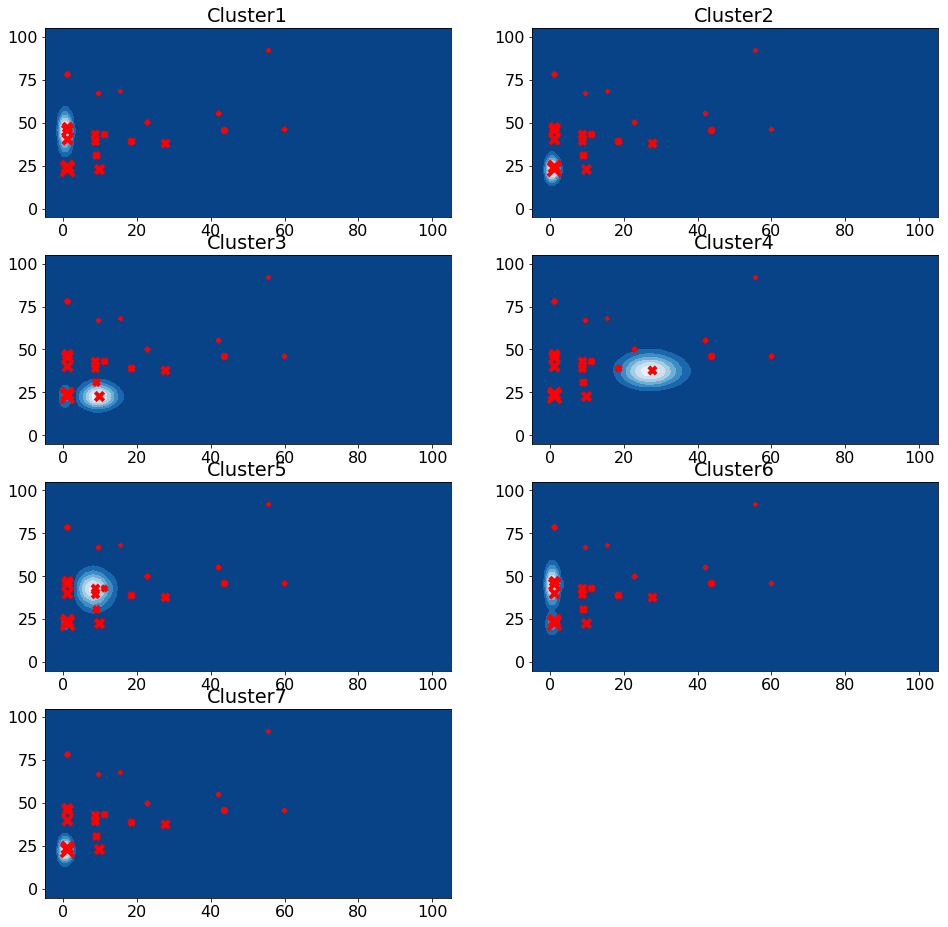

In [33]:
onlineEM.n_clusters = 7

plot_all_categories(onlineEM)

### How about a hierarchical approach

In [17]:
self = onlineEM

closest_centers = []

for host in self.hosts.keys():
    closest_centers.append(self.hosts[host]['group'])

<function print>

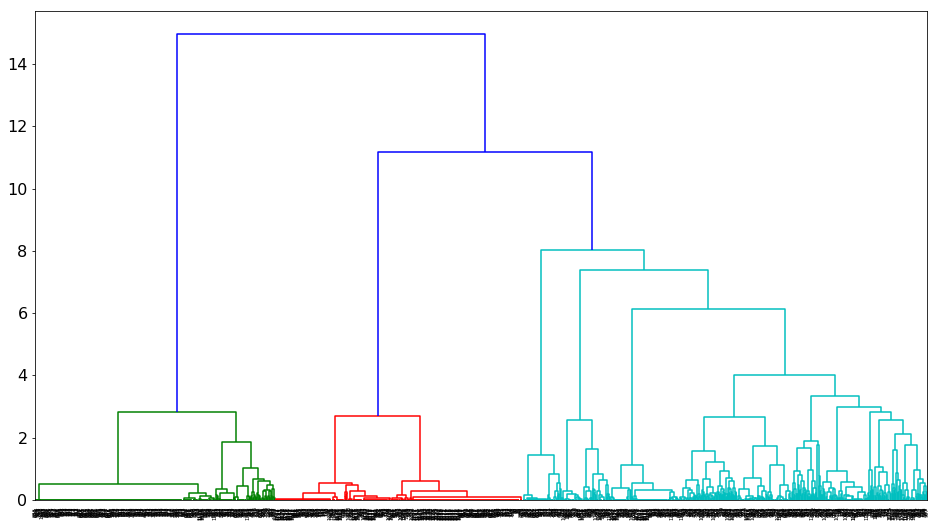

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(closest_centers, 'ward') # εκπαιδεύει τον αλγόριθμο
dendrogram(Z) # σχεδιάζει ένα δενδρόγραμμα με το αποτέλεσμα του ιεραρχικού αλγορίθμου
print

In [10]:
onlineEM.probabilities_per_kMean_cluster[1]

array([  2.52873546e-01,   1.85191678e-10,   3.23269428e-03,
         1.77688995e-03,   3.47749091e-03,   1.51927051e-02,
         5.06538379e-01,   3.39769360e-07,   1.01464089e-03,
         5.61128355e-02,   1.41343177e-01,   2.37377322e-07,
         9.75501297e-04,   7.27767119e-04,   5.28596230e-03,
         5.55130196e-03,   2.52505533e-06,   2.36244366e-03,
         2.04879233e-03,   1.48276919e-03])

In [13]:
onlineEM.counts_per_kMeans_cluster

array([ 164.,   39.,  100.,   38.,  247.,   29.,   22.,   26.,   51.,
         60.,   22.,   65.,   27.,   38.,   35.,    7.,    8.,   60.,
        178.,    2.])

In [20]:
for host in onlineEM.hosts:
    if onlineEM.hosts[host]['category'] == 19:
        print(host)

C1685
C1707


In [21]:
onlineEM.hosts['C1685']['group']

array([  2.66616284e-37,   9.19213445e-57,   5.33293874e-05,
         5.40050818e-65,   2.03938168e-10,   2.21370724e-28,
         7.08175611e-83,   8.74979483e-01,   4.43550090e-03,
         7.67315226e-76,   1.62087344e-31,   7.90241785e-02,
         8.67811590e-64,   4.12588343e-02,   1.26359882e-11,
         3.68036624e-21,   5.25230184e-14,   8.13247381e-66,
         2.81440781e-12,   2.48673339e-04])

In [27]:
groupped_data.values[np.where(groupped_data.values[:,2] == 'C1707')[0]]

array([[59, 91, 'C1707'],
       [59, 85, 'C1707'],
       [65, 92, 'C1707'],
       [58, 92, 'C1707'],
       [58, 86, 'C1707'],
       [59, 94, 'C1707'],
       [57, 45, 'C1707'],
       [43, 100, 'C1707']], dtype=object)

In [23]:
onlineEM.lambdas[7]

array([55.61558612007878, 91.73673614509795], dtype=object)

- distance to its cluster center

In [25]:
onlineEM.lambdas[10]

array([9.043762225890246, 44.88816286108403], dtype=object)

In [11]:
onlineEM.gammas

array([  1.22543565e-02,   6.70842085e-03,   3.03779986e-01,
         3.44745268e-02,   1.28172356e-01,   4.75268038e-02,
         8.24997334e-02,   6.33231129e-03,   1.14009668e-01,
         4.54031786e-02,   5.56361043e-03,   1.09412768e-03,
         1.23348254e-02,   2.88186422e-03,   4.08215613e-03,
         1.34077304e-01,   1.61439828e-03,   3.57922863e-02,
         2.07236316e-04,   2.11908498e-02])

#### Here are the anomalies from this data set 

In [10]:
onlineEM.threshold = 0.0000000005

In [82]:
result = onlineEM.flag_anomaly(groupped_data.values)
print('total anomalies:', np.sum(result))
anomalies = np.where(result == True)
print(groupped_data.values[anomalies])

total anomalies: 5000
[[98 81 'C0']
 [93 82 'C1']
 [97 82 'C10']
 ..., 
 [94 82 'C97']
 [94 81 'C98']
 [92 82 'C99']]


In [11]:
r = onlineEM.score_anomaly(groupped_data.values)

In [12]:
flags = r < onlineEM.threshold
print(groupped_data.values[flags])

[[13 83 'C5698']
 [100 25 'C16712']
 [13 79 'C20101']
 [86 25 'C16712']
 [17 78 'C20101']]


In [33]:
flags[flags == True]

array([], dtype=bool)

In [40]:
onlineEM.score_anomaly([[79, 100, 'C4'],
 [16, 60, 'C299'],
 [16, 61, 'C359'],
 [16, 61, 'C428'],
 [16, 62, 'C134'],
 [16, 60, 'C277'],
 [16, 61, 'C158'],
 [16, 61, 'C179']])

array([  4.23534552e-09,   6.26756036e-09,   6.24738791e-09,
         6.24738791e-09,   3.32587442e-09,   3.40226241e-09,
         6.24738791e-09,   3.39131206e-09])

In [19]:
onlineEM.hosts['C16712']

{'category': 4,
 'group': array([  9.74782562e-02,   9.67865820e-03,   3.93054962e-02,
          2.22283995e-03,   4.95570123e-04,   7.32309506e-03,
          7.47749968e-05,   4.56620742e-02,   3.95773956e-04,
          3.14459310e-03,   3.73306235e-03,   7.56264202e-01,
          3.09370379e-12,   1.19716852e-09,   2.69560522e-02,
          4.87550920e-03,   6.70734118e-10,   2.17747867e-03,
          1.95539275e-04,   1.70222900e-05]),
 'n_points': 21}

In [21]:
onlineEM.probabilities_per_kMean_cluster[4]

array([ 0.04140676,  0.03096328,  0.07349746,  0.13438049,  0.09532232,
        0.01196119,  0.02387321,  0.01198826,  0.0866894 ,  0.14598719,
        0.00759718,  0.00899978,  0.06000448,  0.00986295,  0.02780956,
        0.08656514,  0.00552514,  0.12967956,  0.00159428,  0.00629237])